In [1]:
import sys
import os
os.chdir('./..')
sys.path.append('scripts')

In [2]:
import pickle

import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d,make_smoothing_spline
import matplotlib.pyplot as plt
import torch
from uncertainties import ufloat,umath

from sbi.analysis import pairplot
from sbi.inference import NPE,NPE_A
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

# if torch.cuda.is_available():
#     device = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     device = torch.device('mps')
# else:
#     device = torch.device('cpu')
device = torch.device('cpu')

# Perform Curve Fits to Quast EEG PSDs

In [3]:
no_power = np.array([
    [25.982256055857825, 0.3789096175722008],
    [26.313108967161075, 0.3729998477139113],
    [26.661775364168108, 0.369264435522993],
    [27.15128415830467, 0.3732192839555908],
    [27.485540459152947, 0.3787336792383785],
    [27.984752534120027, 0.37830372687210684],
    [28.286712840562256, 0.3689003681421064],
    [28.356228882333127, 0.3775427874523387],
    [28.699235667386777, 0.35999984489734943],
    [28.6169140389739, 0.3695770446168284],
    [29.092664449843312, 0.35654707121710344],
    [29.336405071302433, 0.3563564795234446],
    [29.7056579284736, 0.35115713996543585],
    [30.220127752314653, 0.34894589809337706],
    [30.783497340832763, 0.35205794827055026],
    [31.332779398158674, 0.35233009800773785],
    [31.38017669936609, 0.345042668956083],
    [31.931339601978006, 0.34462555132722406],
    [32.24217561732491, 0.3353017087778316],
    [32.34471177893695, 0.34389935937832944],
    [32.76470453130264, 0.334822348968674],
    [33.07835429119741, 0.3317422515484134],
    [33.390348907240494, 0.33407752429686804],
    [33.56993201514858, 0.3300905280481667],
    [34.15212886497963, 0.33370633035162406],
    [34.039165297101974, 0.3281531235406928],
    [34.70391244653594, 0.3358724791970132],
    [35.31515053750154, 0.3343292013191838],
    [35.46424415340486, 0.3322183282177297],
    [35.88542958295779, 0.3383839390938701],
    [36.46179935281688, 0.3383051084574884],
    [36.89040919786042, 0.33273441195494635],
    [37.03704459847086, 0.3381874895156573],
    [37.407217520900744, 0.33129900549960656],
    [37.8390348156657, 0.3371806367797768],
    [38.09542633443239, 0.33318574401429035],
    [38.37398704467138, 0.3377120779534525],
    [38.98523166909956, 0.3350441232952216],
    [39.53195489173284, 0.3351705204154319],
    [39.643896164878576, 0.3311377041896566],
    [40.04315606268102, 0.34158319479485044],
    [40.61132774618989, 0.343392495250876],
    [41.16021482600574, 0.34223345859491555],
    [41.254930432918556, 0.3376440900043977],
    [41.865208104886, 0.3367959491005597],
    [41.75544593366884, 0.3317037453472187],
    [42.44694761233699, 0.33916050252940605],
    [42.32895327827854, 0.3320124950695253],
    [43.006734685544544, 0.3385401931914867],
    [43.20914904246562, 0.3299275263565372],
    [43.70055825629614, 0.3280732218268432],
    [43.88263681185754, 0.3226838427455473],
    [44.31595347222931, 0.3270553467502693],
    [44.47699896899851, 0.3210430585070036],
    [45.026358635940426, 0.32384904407850285],
    [45.53910477862634, 0.32992475885202355],
    [45.40503812663965, 0.32453389068476546],
    [46.19578310178333, 0.3203314639089256],
    [46.82837908189827, 0.30839314131307033],
    [47.38624531710953, 0.30517933738542435],
    [47.82941008339884, 0.301549189135274],
    [48.18567979747456, 0.2944479455222222],
    [54.111922358441454, 0.26686630366283254],
    [54.763635250043386, 0.26563130477360614],
    [55.643447653706, 0.2525094415755756],
    [55.79768637138512, 0.2525952053873274],
    [56.327746189888025, 0.2427838253229177],
    [56.405951736880255, 0.2508113181028893],
    [57.21407572246665, 0.2427838253229177],
    [57.76151455141227, 0.2427838253229177],
    [58.73473913620449, 0.2372263303213989],
]).T

md_power = np.array([
    [25.749377315925404, 0.5197323262319385],
    [26.31419515531374, 0.5105212928497916],
    [26.7052228902749, 0.5050152561353239],
    [27.248316966609845, 0.48870297914012517],
    [27.600241928074887, 0.49163610150203785],
    [27.817479558608866, 0.48299110927745303],
    [29.1904213835836, 0.47866861316516063],
    [30.12019844226902, 0.44938884783308464],
    [30.02461388483407, 0.4657011248282834],
    [30.350470330635037, 0.43953458586279903],
    [31.56787001214745, 0.4342909864122919],
    [31.74513591866317, 0.44433564404466663],
    [32.70098149301267, 0.44491197685963896],
    [32.68360248256995, 0.43482615259762336],
    [33.335315374171884, 0.42926865759610455],
    [34.44322728989516, 0.41452585835596434],
    [36.18721098782194, 0.4164246691481499],
    [36.680774884395134, 0.4095086753684821],
    [37.01097608280678, 0.3999760276922658],
    [37.48020936476017, 0.4014811825885105],
    [38.105853740698024, 0.40425993008926986],
    [39.0443203046048, 0.4191142222846875],
    [39.46141655523004, 0.42905253279048994],
    [39.98278686851158, 0.4451178100078434],
    [40.08706093116789, 0.46153300357714433],
    [40.58236272878536, 0.48175611038822663],
    [40.92125343241837, 0.49348859983587745],
    [41.919305174985894, 0.4943560395318818],
    [42.60267269275135, 0.5137117066469599],
    [42.95459765421639, 0.5214819079916759],
    [43.580242030154245, 0.525598570955764],
    [44.02340679644356, 0.5167992038700259],
    [44.43398591815278, 0.490658394048067],
    [44.414434531404716, 0.5069192127562147],
    [44.67511968804549, 0.4694061214959626],
    [44.83153078202995, 0.4492344729719314],
    [45.31379832181538, 0.4367558383620396],
    [45.45717515796781, 0.42057220708446863],
    [45.81344487204353, 0.4093543005073288],
    [46.134956565233814, 0.39615524987872164],
    [46.16623878403071, 0.38943994341855304],
    [46.838806488163904, 0.3517724772971477],
    [47.15162867613283, 0.3437449845171761],
    [47.88154711472699, 0.3354087420148979],
    [48.87215070996193, 0.30978251506345006],
    [49.88882282086094, 0.30329877089501145],
    [50.723015322111415, 0.29650627700426624],
    [51.45293376070558, 0.29311003005889363],
    [52.02644110531528, 0.2756656707485707],
    [51.97430407398712, 0.28230378977816256],
    [52.65208548125313, 0.26177193324477366],
    [52.96490766922206, 0.2591475606051675],
    [53.43414095117545, 0.24826413289385985],
    [53.90337423312884, 0.2452538231013705],
    [55.238082235129596, 0.23240983465341591],
    [55.45705776670784, 0.2296928370971178],
    [56.484157283872484, 0.23166883531988008],
    [57.070698886314226, 0.23151446045872676],
    [57.29228126945888, 0.22240634365068201],
    [57.996131192388965, 0.2134526017037906]
]).T

sortidx = np.argsort(no_power[0])
no_power = no_power[:,sortidx]
sortidx = np.argsort(md_power[0])
md_power = md_power[:,sortidx]
del sortidx

In [12]:
def rational(x, p, q):
    return np.polyval(p, x) / np.polyval(q + [1.0], x)

def rational3_4(x, p2, p1, p0, q3, q2, q1):
    return rational(x, [p2, p1, p0], [q3, q2, q1])

def lfp_bgnd_func(f, B, beta):
    return B/f**beta

def lfp_nois_func(x, p2, p1, p0, q2, q1):
    return rational(x, [p2, p1, p0], [q2, q1])

def lfp_sign_func(f, A, p0, q0, q2):
    return A * (p0 + f**2) / (q0 + q2*f**2 + f**4)

def lfp_sign_func_d2(f, A, p0, q0, q2):
    return A * (-((4*f*(2*q2*f+4*f**3))/(q0+q2*f**2+f**4)**2)+2/(q0+q2*f**2+f**4)+\
        (p0+f**2)*((2*(2*q2*f+4*f**3)**2)/(q0+q2*f**2+f**4)**3-(2*q2+12*f**2)/(q0+q2*f**2+f**4)**2))

def lfp_add_func(f, A, p0, q0, q2, B, beta):
    return lfp_sign_func(f,A,p0,q0,q2) + lfp_bgnd_func(f,B,beta)

def lfp_mult_func(f, A, p0, q0, q2, a2, a1, a0, b2, b1):
    return lfp_sign_func(f,A,p0,q0,q2) * lfp_nois_func(f,a2,a1,a0,b2,b1)

In [5]:
tail_idxs = list(range(15))# + [-4,-3,-2,-1]

no_bgnd_popt,no_bgnd_perr = curve_fit(lfp_bgnd_func,no_power[0,tail_idxs],no_power[1,tail_idxs],
                                      p0=[0.1,0.5],maxfev=1000000)
no_bgnd_cnum = np.linalg.cond(no_bgnd_perr/no_bgnd_popt[:,None]/no_bgnd_popt[None,:])
no_bgnd_perr = np.sqrt(np.diag(no_bgnd_perr))
md_bgnd_popt,md_bgnd_perr = curve_fit(lfp_bgnd_func,md_power[0,tail_idxs],md_power[1,tail_idxs],
                                      p0=[0.1,0.5],maxfev=1000000)
md_bgnd_cnum = np.linalg.cond(md_bgnd_perr/md_bgnd_popt[:,None]/md_bgnd_popt[None,:])
md_bgnd_perr = np.sqrt(np.diag(md_bgnd_perr))

print(no_bgnd_popt,no_bgnd_perr)
print(md_bgnd_popt,md_bgnd_perr)

no_bgnd_popt,no_bgnd_perr = curve_fit(lambda x,b,m: np.log(b)-m*x,np.log(no_power[0,tail_idxs]),np.log(no_power[1,tail_idxs]),
                                      p0=[0.1,0.5],maxfev=1000000)
no_bgnd_cnum = np.linalg.cond(no_bgnd_perr/no_bgnd_popt[:,None]/no_bgnd_popt[None,:])
no_bgnd_perr = np.sqrt(np.diag(no_bgnd_perr))
md_bgnd_popt,md_bgnd_perr = curve_fit(lambda x,b,m: np.log(b)-m*x,np.log(md_power[0,tail_idxs]),np.log(md_power[1,tail_idxs]),
                                      p0=[0.1,0.5],maxfev=1000000)
md_bgnd_cnum = np.linalg.cond(md_bgnd_perr/md_bgnd_popt[:,None]/md_bgnd_popt[None,:])
md_bgnd_perr = np.sqrt(np.diag(md_bgnd_perr))

print(no_bgnd_popt,no_bgnd_perr)
print(md_bgnd_popt,md_bgnd_perr)

[1.84543732 0.48402037] [0.58935268 0.09561017]
[5.68190102 0.73867854] [1.03220957 0.05385467]
[1.89564403 0.4920959 ] [0.60248507 0.0950874 ]
[5.54244713 0.73136077] [1.04488516 0.05571949]


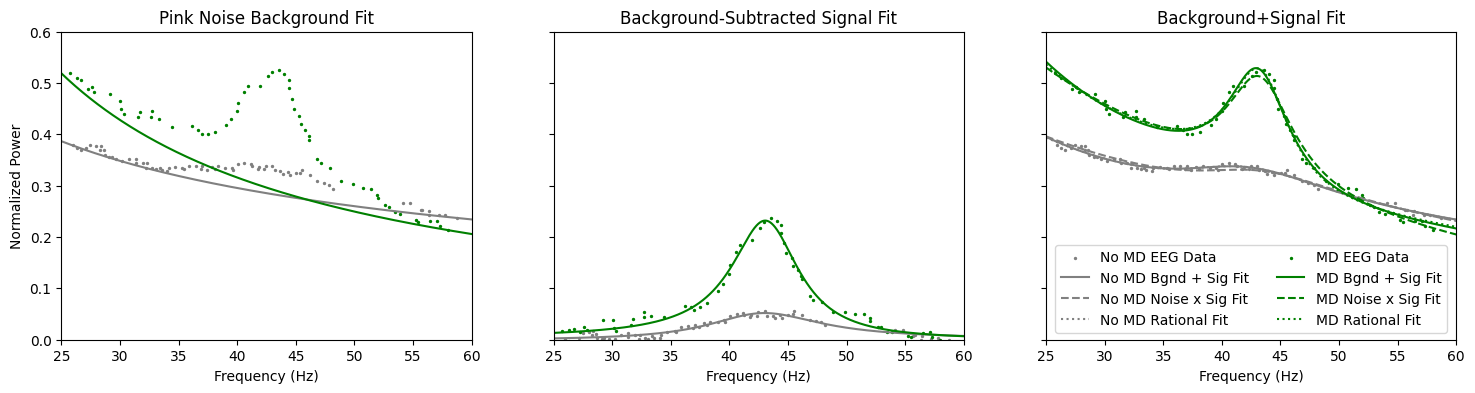

In [6]:
err_fact = 0.05
no_err = err_fact*no_power[1]
md_err = err_fact*md_power[1]
tail_idxs = list(range(10)) + [-4,-3,-2,-1]
# tail_idxs = [0,1,2,3] + [-4,-3,-2,-1]
abs_sig = False
bgnd_scale = [5,0.7]
sign_scale = [1,40**2,40**4,40**2]

no_rat_popt,no_rat_perr = curve_fit(rational3_4,no_power[0],no_power[1],
                                    # sigma=no_err,absolute_sigma=True,
                                    maxfev=1000000)
no_rat_cnum = np.linalg.cond(no_rat_perr/no_rat_popt[:,None]/no_rat_popt[None,:])
no_rat_perr = np.sqrt(np.diag(no_rat_perr))
md_rat_popt,md_rat_perr = curve_fit(rational3_4,md_power[0],md_power[1],
                                    # sigma=md_err,absolute_sigma=True,
                                    maxfev=1000000)
md_rat_cnum = np.linalg.cond(md_rat_perr/md_rat_popt[:,None]/md_rat_popt[None,:])
md_rat_perr = np.sqrt(np.diag(md_rat_perr))

no_bgnd_popt,no_bgnd_perr = curve_fit(lfp_bgnd_func,no_power[0,tail_idxs],no_power[1,tail_idxs],
                                    #   sigma=no_err[tail_idxs],absolute_sigma=True,
                                      p0=[5,0.5],method='trf',x_scale=bgnd_scale,maxfev=1000000)
no_bgnd_cnum = np.linalg.cond(no_bgnd_perr/no_bgnd_popt[:,None]/no_bgnd_popt[None,:])
no_bgnd_perr = np.sqrt(np.diag(no_bgnd_perr))
md_bgnd_popt,md_bgnd_perr = curve_fit(lfp_bgnd_func,md_power[0,tail_idxs],md_power[1,tail_idxs],
                                    #   sigma=md_err[tail_idxs],absolute_sigma=True,
                                      p0=[5,0.5],method='trf',x_scale=bgnd_scale,maxfev=1000000)
md_bgnd_cnum = np.linalg.cond(md_bgnd_perr/md_bgnd_popt[:,None]/md_bgnd_popt[None,:])
md_bgnd_perr = np.sqrt(np.diag(md_bgnd_perr))

no_bgnd_popt[0] *= no_power[1,-1]/lfp_bgnd_func(no_power[0,-1],*no_bgnd_popt)
md_bgnd_popt[0] *= md_power[1,-1]/lfp_bgnd_func(md_power[0,-1],*md_bgnd_popt)

no_sign_popt,no_sign_perr = curve_fit(lfp_sign_func,no_power[0],no_power[1]-lfp_bgnd_func(no_power[0],*no_bgnd_popt),
                                    #   sigma=no_err,absolute_sigma=True,
                                      p0=[1000,100,40**4,-1000],method='trf',x_scale=sign_scale,maxfev=1000000)
no_sign_cnum = np.linalg.cond(no_sign_perr/no_sign_popt[:,None]/no_sign_popt[None,:])
no_sign_perr = np.sqrt(np.diag(no_sign_perr))
md_sign_popt,md_sign_perr = curve_fit(lfp_sign_func,md_power[0],md_power[1]-lfp_bgnd_func(md_power[0],*md_bgnd_popt),
                                    #   sigma=md_err,absolute_sigma=True,
                                      p0=[1000,100,40**4,-1000],method='trf',x_scale=sign_scale,maxfev=1000000)
md_sign_cnum = np.linalg.cond(md_sign_perr/md_sign_popt[:,None]/md_sign_popt[None,:])
md_sign_perr = np.sqrt(np.diag(md_sign_perr))

no_nois_popt,no_nois_perr = curve_fit(lfp_nois_func,no_power[0],no_power[1]/lfp_sign_func(no_power[0],*no_sign_popt),
                                    #   sigma=no_power[1]/lfp_sign_func(no_power[0],*no_sign_popt)*err_fact,absolute_sigma=True,
                                      maxfev=1000000)
no_nois_cnum = np.linalg.cond(no_nois_perr/no_nois_popt[:,None]/no_nois_popt[None,:])
no_nois_perr = np.sqrt(np.diag(no_nois_perr))
md_nois_popt,md_nois_perr = curve_fit(lfp_nois_func,md_power[0],md_power[1]/lfp_sign_func(md_power[0],*md_sign_popt),
                                    #   sigma=md_power[1]/lfp_sign_func(md_power[0],*md_sign_popt)*err_fact,absolute_sigma=True,
                                      maxfev=1000000)
md_nois_cnum = np.linalg.cond(md_nois_perr/md_nois_popt[:,None]/md_nois_popt[None,:])
md_nois_perr = np.sqrt(np.diag(md_nois_perr))

no_add_p0 = np.concatenate([no_sign_popt,no_bgnd_popt])
md_add_p0 = np.concatenate([md_sign_popt,md_bgnd_popt])

no_add_popt,no_add_perr = curve_fit(lfp_add_func,no_power[0],no_power[1],
                                    #   sigma=no_err,absolute_sigma=True,
                                    p0=no_add_p0,bounds=([0,-np.inf,-np.inf,-np.inf,0,0],
                                                         [np.inf,np.inf,np.inf,np.inf,np.inf,2]),
                                    method='trf',x_scale=sign_scale+bgnd_scale,maxfev=1000000)
no_add_cnum = np.linalg.cond(no_add_perr/no_add_popt[:,None]/no_add_popt[None,:])
no_add_perr = np.sqrt(np.diag(no_add_perr))
md_add_popt,md_add_perr = curve_fit(lfp_add_func,md_power[0],md_power[1],
                                    #   sigma=md_err,absolute_sigma=True,
                                    p0=md_add_p0,bounds=([0,-np.inf,-np.inf,-np.inf,0,0],
                                                         [np.inf,np.inf,np.inf,np.inf,np.inf,2]),
                                    method='trf',x_scale=sign_scale+bgnd_scale,maxfev=1000000)
md_add_cnum = np.linalg.cond(md_add_perr/md_add_popt[:,None]/md_add_popt[None,:])
md_add_perr = np.sqrt(np.diag(md_add_perr))

no_mult_p0 = np.concatenate([no_sign_popt,no_nois_popt])
md_mult_p0 = np.concatenate([md_sign_popt,md_nois_popt])

no_mult_popt,no_mult_perr = curve_fit(lfp_mult_func,no_power[0],no_power[1],
                                    #   sigma=no_err,absolute_sigma=True,
                                      p0=no_mult_p0,bounds=([0,-np.inf,-np.inf,-np.inf]+([-np.inf]*5),
                                                            [np.inf,np.inf,np.inf,np.inf]+([np.inf]*5)),
                                      maxfev=1000000)
no_mult_cnum = np.linalg.cond(no_mult_perr/no_mult_popt[:,None]/no_mult_popt[None,:])
no_mult_perr = np.sqrt(np.diag(no_mult_perr))
md_mult_popt,md_mult_perr = curve_fit(lfp_mult_func,md_power[0],md_power[1],
                                    #   sigma=md_err,absolute_sigma=True,
                                      p0=md_mult_p0,bounds=([0,-np.inf,-np.inf,-np.inf]+([-np.inf]*5),
                                                            [np.inf,np.inf,np.inf,np.inf]+([np.inf]*5)),
                                      maxfev=1000000)
md_mult_cnum = np.linalg.cond(md_mult_perr/md_mult_popt[:,None]/md_mult_popt[None,:])
md_mult_perr = np.sqrt(np.diag(md_mult_perr))

fs = np.linspace(25,60,1000)

fig,axs = plt.subplots(1,3,figsize=(6*3,4*1),sharex=True,sharey=True)

axs[0].scatter(no_power[0],no_power[1],c='gray',s=2,label='No MD EEG Data')
axs[0].plot(fs,lfp_bgnd_func(fs,*no_bgnd_popt),c='gray',label='No MD Pink Noise Fit')
axs[0].scatter(md_power[0],md_power[1],c='g',s=2,label='MD EEG Data')
axs[0].plot(fs,lfp_bgnd_func(fs,*md_bgnd_popt),c='g',label='MD Pink Noise Fit')
axs[0].set_title('Pink Noise Background Fit')

axs[1].scatter(no_power[0],no_power[1]-lfp_bgnd_func(no_power[0],*no_bgnd_popt),
               c='gray',s=2,label='No MD EEG Periodic Data')
axs[1].plot(fs,lfp_sign_func(fs,*no_sign_popt),c='gray',label='No MD Periodic Fit')
axs[1].scatter(md_power[0],md_power[1]-lfp_bgnd_func(md_power[0],*md_bgnd_popt),
               c='g',s=2,label='MD EEG Periodic Data')
axs[1].plot(fs,lfp_sign_func(fs,*md_sign_popt),c='g',label='MD Periodic Fit')
axs[1].set_title('Background-Subtracted Signal Fit')

axs[2].scatter(no_power[0],no_power[1],c='gray',s=2,label='No MD EEG Data')
axs[2].plot(fs,lfp_add_func(fs,*no_add_popt),c='gray',label='No MD Bgnd + Sig Fit')
axs[2].plot(fs,lfp_mult_func(fs,*no_mult_popt),c='gray',ls='--',label='No MD Noise x Sig Fit')
axs[2].plot(fs,rational3_4(fs,*no_rat_popt),c='gray',ls=':',label='No MD Rational Fit')
axs[2].scatter(md_power[0],md_power[1],c='g',s=2,label='MD EEG Data')
axs[2].plot(fs,lfp_add_func(fs,*md_add_popt),c='g',label='MD Bgnd + Sig Fit')
axs[2].plot(fs,lfp_mult_func(fs,*md_mult_popt),c='g',ls='--',label='MD Noise x Sig Fit')
axs[2].plot(fs,rational3_4(fs,*md_rat_popt),c='g',ls=':',label='MD Rational Fit')
axs[2].set_title('Background+Signal Fit')

for i in range(3):
    axs[i].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Normalized Power')

axs[0].set_xlim(25,60)
axs[1].set_ylim(0,0.6)

axs[2].legend(ncol=2,loc='lower center')

In [7]:
print('Separate Background Plus Signal Fit Results:')
print('------------------------------------------')
print('No MD Background Parameters: B = {:.3f} +- {:.3f}, β = {:.3f} +- {:.3f}'.format(
    no_bgnd_popt[0],no_bgnd_perr[0],no_bgnd_popt[1],no_bgnd_perr[1]))
print('   MD Background Parameters: B = {:.3f} +- {:.3f}, β = {:.3f} +- {:.3f}'.format(
    md_bgnd_popt[0],md_bgnd_perr[0],md_bgnd_popt[1],md_bgnd_perr[1]))
print()
print('No MD Signal Parameters: A = {:.6f} +- {:.6f}, p0 = {:.0f} +- {:.0f}, q0 = {:.0f} +- {:.0f}, q2 = {:.0f} +- {:.0f}'.format(
    no_sign_popt[0],no_sign_perr[0],no_sign_popt[1],no_sign_perr[1],
    no_sign_popt[2],no_sign_perr[2],no_sign_popt[3],no_sign_perr[3]))
print('   MD Signal Parameters: A = {:.6f} +- {:.6f}, p0 = {:.0f} +- {:.2f}, q0 = {:.0f} +- {:.0f}, q2 = {:.0f} +- {:.0f}'.format(
    md_sign_popt[0],md_sign_perr[0],md_sign_popt[1],md_sign_perr[1],
    md_sign_popt[2],md_sign_perr[2],md_sign_popt[3],md_sign_perr[3]))
print()
print('Combined Background Plus Signal Fit Results:')
print('------------------------------------------')
print('No MD Background Parameters: B = {:.3f} +- {:.3f}, β = {:.3f} +- {:.3f}'.format(
    no_add_popt[4],no_add_perr[4],no_add_popt[5],no_add_perr[5]))
print('   MD Background Parameters: B = {:.3f} +- {:.3f}, β = {:.3f} +- {:.3f}'.format(
    md_add_popt[4],md_add_perr[4],md_add_popt[5],md_add_perr[5]))
print()
print('No MD Signal Parameters: A = {:.6f} +- {:.6f}, p0 = {:.0f} +- {:.0f}, q0 = {:.0f} +- {:.0f}, q2 = {:.0f} +- {:.0f}'.format(
    no_add_popt[0],no_add_perr[0],no_add_popt[1],no_add_perr[1],
    no_add_popt[2],no_add_perr[2],no_add_popt[3],no_add_perr[3]))
print('   MD Signal Parameters: A = {:.6f} +- {:.6f}, p0 = {:.0f} +- {:.2f}, q0 = {:.0f} +- {:.0f}, q2 = {:.0f} +- {:.0f}'.format(
    md_add_popt[0],md_add_perr[0],md_add_popt[1],md_add_perr[1],
    md_add_popt[2],md_add_perr[2],md_add_popt[3],md_add_perr[3]))
print()
print('No MD Condition Number = {:.4f}'.format(no_add_cnum))
print('   MD Condition Number = {:.4f}'.format(md_add_cnum))
print()
print('No MD RMSE = {:.4f}'.format(np.sqrt(np.mean((no_power[1]-lfp_add_func(no_power[0],*no_add_popt))**2))))
print('   MD RMSE = {:.4f}'.format(np.sqrt(np.mean((md_power[1]-lfp_add_func(md_power[0],*md_add_popt))**2))))
print()
print('No MD R^2 = {:.4f}'.format(1-np.mean((no_power[1]-lfp_add_func(no_power[0],*no_add_popt))**2)/\
    np.var(no_power[1])))
print('   MD R^2 = {:.4f}'.format(1-np.mean((md_power[1]-lfp_add_func(md_power[0],*md_add_popt))**2)/\
    np.var(md_power[1])))

Separate Background Plus Signal Fit Results:
------------------------------------------
No MD Background Parameters: B = 2.441 +- 0.174, β = 0.572 +- 0.020
   MD Background Parameters: B = 15.548 +- 1.481, β = 1.056 +- 0.027

No MD Signal Parameters: A = 7.443379 +- 1.950629, p0 = -73 +- 351, q0 = 3404208 +- 110345, q2 = -3553 +- 65
   MD Signal Parameters: A = 0.000255 +- 0.000012, p0 = 83644842 +- 0.00, q0 = 3525461 +- 22036, q2 = -3706 +- 11

Combined Background Plus Signal Fit Results:
------------------------------------------
No MD Background Parameters: B = 4.009 +- 0.824, β = 0.716 +- 0.058
   MD Background Parameters: B = 15.753 +- 1.167, β = 1.053 +- 0.022

No MD Signal Parameters: A = 32.285489 +- 12.954218, p0 = -840 +- 177, q0 = 3123602 +- 208159, q2 = -3257 +- 150
   MD Signal Parameters: A = 0.000170 +- 0.000014, p0 = 105798234 +- 0.00, q0 = 3521383 +- 20744, q2 = -3711 +- 10

No MD Condition Number = 511593.5719
   MD Condition Number = 3136096950257542656.0000

No MD R

In [8]:
print('Separate Noise Times Signal Fit Results:')
print('---------------------------------------')
print(('No MD Noise Parameters: a2 = {:.3f} +- {:.3f}, a1 = {:.3f} +- {:.3f}, a0 = {:.3f} +- {:.3f}, '+\
    'b2 = {:.3f} +- {:.3f}, b1 = {:.3f} +- {:.3f}').format(
        no_nois_popt[0],no_nois_perr[0],no_nois_popt[1],no_nois_perr[1],no_nois_popt[2],no_nois_perr[2],
        no_nois_popt[3],no_nois_perr[3],no_nois_popt[4],no_nois_perr[4]))
print(('   MD Noise Parameters: a2 = {:.3f} +- {:.3f}, a1 = {:.3f} +- {:.3f}, a0 = {:.3f} +- {:.3f}, '+\
    'b2 = {:.3f} +- {:.3f}, b1 = {:.3f} +- {:.3f}').format(
        md_nois_popt[0],md_nois_perr[0],md_nois_popt[1],md_nois_perr[1],md_nois_popt[2],md_nois_perr[2],
        md_nois_popt[3],md_nois_perr[3],md_nois_popt[4],md_nois_perr[4]))
print()
print('No MD Signal Parameters: A = {:.6f} +- {:.6f}, p0 = {:.0f} +- {:.0f}, q0 = {:.0f} +- {:.0f}, q2 = {:.0f} +- {:.0f}'.format(
    no_sign_popt[0],no_sign_perr[0],no_sign_popt[1],no_sign_perr[1],
    no_sign_popt[2],no_sign_perr[2],no_sign_popt[3],no_sign_perr[3]))
print('   MD Signal Parameters: A = {:.6f} +- {:.6f}, p0 = {:.0f} +- {:.2f}, q0 = {:.0f} +- {:.0f}, q2 = {:.0f} +- {:.0f}'.format(
    md_sign_popt[0],md_sign_perr[0],md_sign_popt[1],md_sign_perr[1],
    md_sign_popt[2],md_sign_perr[2],md_sign_popt[3],md_sign_perr[3]))
print()
print('Combined Noise Times Signal Fit Results:')
print('---------------------------------------')
print(('No MD Noise Parameters: a2 = {:.3f} +- {:.3f}, a1 = {:.3f} +- {:.3f}, a0 = {:.3f} +- {:.3f}, '+\
    'b2 = {:.3f} +- {:.3f}, b1 = {:.3f} +- {:.3f}').format(
        no_mult_popt[4],no_mult_perr[4],no_mult_popt[5],no_mult_perr[5],no_mult_popt[6],no_mult_perr[6],
        no_mult_popt[7],no_mult_perr[7],no_mult_popt[8],no_mult_perr[8]))
print(('   MD Noise Parameters: a2 = {:.3f} +- {:.3f}, a1 = {:.3f} +- {:.3f}, a0 = {:.3f} +- {:.3f}, '+\
    'b2 = {:.3f} +- {:.3f}, b1 = {:.3f} +- {:.3f}').format(
        md_mult_popt[4],md_mult_perr[4],md_mult_popt[5],md_mult_perr[5],md_mult_popt[6],md_mult_perr[6],
        md_mult_popt[7],md_mult_perr[7],md_mult_popt[8],md_mult_perr[8]))
print()
print('No MD Signal Parameters: A = {:.6f} +- {:.6f}, p0 = {:.0f} +- {:.0f}, q0 = {:.0f} +- {:.0f}, q2 = {:.0f} +- {:.0f}'.format(
    no_mult_popt[0],no_mult_perr[0],no_mult_popt[1],no_mult_perr[1],
    no_mult_popt[2],no_mult_perr[2],no_mult_popt[3],no_mult_perr[3]))
print('   MD Signal Parameters: A = {:.6f} +- {:.6f}, p0 = {:.0f} +- {:.2f}, q0 = {:.0f} +- {:.0f}, q2 = {:.0f} +- {:.0f}'.format(
    md_mult_popt[0],md_mult_perr[0],md_mult_popt[1],md_mult_perr[1],
    md_mult_popt[2],md_mult_perr[2],md_mult_popt[3],md_mult_perr[3]))
print()
print('No MD Condition Number = {:.4f}'.format(no_mult_cnum))
print('   MD Condition Number = {:.4f}'.format(md_mult_cnum))
print()
print('No MD RMSE = {:.4f}'.format(np.sqrt(np.mean((no_power[1]-lfp_mult_func(no_power[0],*no_mult_popt))**2))))
print('   MD RMSE = {:.4f}'.format(np.sqrt(np.mean((md_power[1]-lfp_mult_func(md_power[0],*md_mult_popt))**2))))
print()
print('No MD R^2 = {:.4f}'.format(1-np.mean((no_power[1]-lfp_mult_func(no_power[0],*no_mult_popt))**2)/\
    np.var(no_power[1])))
print('   MD R^2 = {:.4f}'.format(1-np.mean((md_power[1]-lfp_mult_func(md_power[0],*md_mult_popt))**2)/\
    np.var(md_power[1])))

Separate Noise Times Signal Fit Results:
---------------------------------------
No MD Noise Parameters: a2 = 54.317 +- 1598.758, a1 = -4570.279 +- 134533.703, a0 = 98248.840 +- 2892378.945, b2 = 0.159 +- 4.648, b1 = 0.875 +- 27.612
   MD Noise Parameters: a2 = 0.120 +- 0.011, a1 = -10.362 +- 0.969, a0 = 225.435 +- 21.244, b2 = 0.000 +- 0.000, b1 = 0.000 +- 0.005

No MD Signal Parameters: A = 7.443379 +- 1.950629, p0 = -73 +- 351, q0 = 3404208 +- 110345, q2 = -3553 +- 65
   MD Signal Parameters: A = 0.000255 +- 0.000012, p0 = 83644842 +- 0.00, q0 = 3525461 +- 22036, q2 = -3706 +- 11

Combined Noise Times Signal Fit Results:
---------------------------------------
No MD Noise Parameters: a2 = 55.369 +- 1138735.411, a1 = -4596.125 +- 94524867.782, a0 = 99212.247 +- 2040420487.150, b2 = 0.143 +- 4474.559, b1 = 3.013 +- 94895.171
   MD Noise Parameters: a2 = 0.120 +- 2862.459, a1 = -10.362 +- 246363.063, a0 = 225.435 +- 5359979.840, b2 = 0.000 +- 0.000, b1 = 0.000 +- 0.013

No MD Signal Pa

In [9]:
no_p0 = ufloat(no_add_popt[1],no_add_perr[1])
md_p0 = ufloat(md_add_popt[1],md_add_perr[1])

no_q0 = ufloat(no_add_popt[2],no_add_perr[2])
md_q0 = ufloat(md_add_popt[2],md_add_perr[2])

no_q2 = ufloat(no_add_popt[3],no_add_perr[3])
md_q2 = ufloat(md_add_popt[3],md_add_perr[3])

no_fr = umath.sqrt(umath.sqrt(no_p0**2-no_p0*no_q2+no_q0) - no_p0)
md_fr = umath.sqrt(umath.sqrt(md_p0**2-md_p0*md_q2+md_q0) - md_p0)

no_Ar = 1/(no_q2+2*no_fr**2)
no_A50 = lfp_sign_func(50,1,no_p0,no_q0,no_q2)
no_Ar50 = no_Ar/no_A50
md_Ar = 1/(md_q2+2*md_fr**2)
md_A50 = lfp_sign_func(50,1,md_p0,md_q0,md_q2)
md_Ar50 = md_Ar/md_A50

no_wr = umath.sqrt(-(no_p0+no_fr**2)*(no_q2**2-4*no_q0)**2/8/(no_q2+2*no_fr**2)/\
    (4*no_p0*(2*no_p0*no_q2-2*no_q0+3*no_q2*no_fr**2)-(4*no_q0+no_q2**2-4*no_q2*no_fr**2)*no_fr**2))
md_wr = umath.sqrt(-(md_p0+md_fr**2)*(md_q2**2-4*md_q0)**2/8/(md_q2+2*md_fr**2)/\
    (4*md_p0*(2*md_p0*md_q2-2*md_q0+3*md_q2*md_fr**2)-(4*md_q0+md_q2**2-4*md_q2*md_fr**2)*md_fr**2))
# no_wr = umath.sqrt(-1/(no_q2+2*no_fr**2)/\
#     ((8*(8*no_p0**2*no_q2 - (4*no_q0 + no_q2*(no_q2 - 4*no_fr**2))*no_fr**2 + no_p0*(-8*no_q0 + 12*no_q2*no_fr**2)))/\
#     ((-4*no_q0 + no_q2**2)**2*(no_p0 + no_fr**2))))
# md_wr = umath.sqrt(-1/(md_q2+2*md_fr**2)/\
#     ((8*(8*md_p0**2*md_q2 - (4*md_q0 + md_q2*(md_q2 - 4*md_fr**2))*md_fr**2 + md_p0*(-8*md_q0 + 12*md_q2*md_fr**2)))/\
#     ((-4*md_q0 + md_q2**2)**2*(md_p0 + md_fr**2))))

print(r'$f_r$ =',no_fr,md_fr)
print(r'$A_r/A_\eta$ =',no_Ar,md_Ar)
print(r'$A_r/A_50$ =',no_Ar50,md_Ar50)
print(r'$w_r$ =',no_wr,md_wr)

$f_r$ = 43.4+/-1.4 43.08+/-0.06
$A_r/A_\eta$ = 0.0019+/-0.0013 (1.4+/-0.5)e+03
$A_r/A_50$ = 1.4+/-0.5 6.3+/-1.9
$w_r$ = 6.0+/-2.1 2.3+/-0.4


In [10]:
# no_dict = {
#     'frn':no_fr.n,
#     'frs':no_fr.s,
#     'wrn':no_wr.n,
#     'wrs':no_wr.s,
#     'Arn':no_Ar50.n,
#     'Ars':no_Ar50.s,
# }

# md_dict = {
#     'frn':md_fr.n,
#     'frs':md_fr.s,
#     'wrn':md_wr.n,
#     'wrs':md_wr.s,
#     'Arn':md_Ar50.n,
#     'Ars':md_Ar50.s,
# }

# with open('../results/no_obs.pkl','wb') as handle:
#     pickle.dump(no_dict,handle)

# with open('../results/md_obs.pkl','wb') as handle:
#     pickle.dump(md_dict,handle)

with open('results/no_obs.pkl','rb') as handle:
    no_dict = pickle.load(handle)
no_fr = ufloat(no_dict['frn'],no_dict['frs'])
no_wr = ufloat(no_dict['wrn'],no_dict['wrs'])
no_Ar50 = ufloat(no_dict['Arn'],no_dict['Ars'])

with open('results/md_obs.pkl','rb') as handle:
    md_dict = pickle.load(handle)
md_fr = ufloat(md_dict['frn'],md_dict['frs'])
md_wr = ufloat(md_dict['wrn'],md_dict['wrs'])
md_Ar50 = ufloat(md_dict['Arn'],md_dict['Ars'])

# Use SBI to Infer Weights and Inputs from Rates and LFP PSD Peak Features

In [7]:
k = torch.tensor([0.04,0.03])
n = torch.tensor([1.5,2.0])
t = torch.tensor([0.02,0.01])

def calc_eff_coup(W,r,k,n):
    v = (r/k)**1/n
    h = v - W@r
    Weff = W*(n*k*v**(n-1))[None,:]
    
    return Weff

def calc_net_params(Weff,r,k,n):
    v = (r/k)**1/n
    W = Weff/(n*k*v**(n-1))[None,:]
    h = v - W@r
    
    return W,h

def calc_jac_eigvals(Weff,t):
    return torch.eigvals(t[:,None]*Weff)

def calc_lfp(f,Weff,c,a,t):
    G = torch.linalg.inv(2*np.pi*1j*f*torch.diag(t) + torch.eye(2) - Weff)
    A = G@torch.tensor([[1.0,c],[c,1.0]],dtype=torch.cfloat)@G.conj().T
    return A[0,0]

def calc_lfp_params(Weff,c,a,t):
    p0 = (a**2*Weff[0,1]**2 - 2*a*c*Weff[0,1]*(Weff[1,1]-1) + (Weff[1,1]-1)**2)/t[1]**2/(2*np.pi)**2
    q0 = (Weff[0,1]*Weff[1,0] - (Weff[0,0]-1)*(Weff[1,1]-1))**2/t[0]**2/t[1]**2/(2*np.pi)**4
    q2 = ((Weff[0,0]-1)**2*t[1]**2+2*Weff[0,1]*Weff[1,0]*t[0]*t[1]+(Weff[1,1]-1)**2*t[0]**2)/t[0]**2/t[1]**2/(2*np.pi)**2
    
    return p0,q0,q2

def calc_lfp_observ(Weff,c,a,t):
    p0,q0,q2 = calc_lfp_params(Weff,c,a,t)
    
    fr = torch.sqrt(torch.sqrt(p0**2-p0*q2+q0) - p0)
    # fr = torch.sqrt(torch.maximum(torch.tensor(0),torch.sqrt(p0**2-p0*q2+q0) - p0))
    Ar = 1/(q2+2*fr**2)
    # Ar = lfp_sign_func(fr,1,p0,q0,q2)
    A50 = lfp_sign_func(50,1,p0,q0,q2)
    wr = torch.sqrt(-Ar/((8*(8*p0**2*q2 - (4*q0 + q2*(q2 - 4*fr**2))*fr**2 + p0*(-8*q0 + 12*q2*fr**2)))/\
       ((-4*q0 + q2**2)**2*(p0 + fr**2))))
    # wr = torch.sqrt(-Ar/lfp_sign_func_d2(fr,1,p0,q0,q2))
    
    return fr,wr,Ar/A50

def create_sbi_func(t):
    def sbi_func(theta):
        WeffEE,WeffEI,WeffIE,WeffII,c,a = theta
        return torch.tensor(calc_lfp_observ(torch.tensor([[WeffEE,WeffEI],[WeffIE,WeffII]]),c,a,t))
    return sbi_func

def simulator(theta):
    '''
    theta[0] = Weff_EE
    theta[1] = Weff_EI
    theta[2] = Weff_IE
    theta[3] = Weff_II
    theta[4] = r(eta_E,eta_I)
    theta[5] = |eta_I|/|eta_E|
    
    returns: [fr,wr,Ar]
    fr = peak frequency
    wr = width of peak
    Ar = amplitude of peak (relative to amplitude at 50 Hz)
    '''
    tr = (theta[0]-1)/t[0] + (theta[3]-1)/t[1]
    det = ((theta[0]-1)*(theta[3]-1) - theta[1]*theta[2])/t[0]/t[1]
    
    lam = 0.5*(tr + torch.sqrt(torch.maximum(torch.tensor(0),tr**2-4*det)))
    
    if lam >= 0:
        return torch.tensor([torch.nan,torch.nan,torch.nan])
    
    p0 = (theta[5]**2*theta[1]**2 - 2*theta[5]*theta[4]*theta[1]*(theta[3]-1) +\
        (theta[3]-1)**2)/t[1]**2/(2*np.pi)**2
    q0 = (theta[1]*theta[2] - (theta[0]-1)*(theta[3]-1))**2/t[0]**2/t[1]**2/(2*np.pi)**4
    q2 = ((theta[0]-1)**2*t[1]**2+2*theta[1]*theta[2]*t[0]*t[1]+(theta[3]-1)**2*t[0]**2)/t[0]**2/t[1]**2/(2*np.pi)**2
    
    if q2**2 > 4*q0:
        return torch.tensor([torch.nan,torch.nan,torch.nan])
    
    fr = torch.sqrt(torch.sqrt(p0**2-p0*q2+q0) - p0)
    # fr = torch.sqrt(torch.maximum(torch.tensor(0),torch.sqrt(p0**2-p0*q2+q0) - p0))
    Ar = 1/(q2+2*fr**2) / lfp_sign_func(50,1,p0,q0,q2)
    # Ar = lfp_sign_func(fr,1,p0,q0,q2) / lfp_sign_func(50,1,p0,q0,q2)
    wr = torch.sqrt(-(p0+fr**2)*(q2**2-4*q0)**2/8/(q2+2*fr**2)/\
        (4*p0*(2*p0*q2-2*q0+3*q2*fr**2)-(4*q0+q2**2-4*q2*fr**2)*fr**2))
    # wr = torch.sqrt(-Ar/lfp_sign_func_d2(fr,1,p0,q0,q2))
    
    return torch.tensor([fr,wr,Ar])

def max_re_eigval(theta):
    '''
    theta[0] = Weff_EE
    theta[1] = Weff_EI
    theta[2] = Weff_IE
    theta[3] = Weff_II
    theta[4] = r(eta_E,eta_I)
    theta[5] = |eta_I|/|eta_E|
    
    returns: lam
    lam = max(Re(eig(Weff)))
    '''
    tr = (theta[0]-1)/t[0] + (theta[3]-1)/t[1]
    det = ((theta[0]-1)*(theta[3]-1) - theta[1]*theta[2])/t[0]/t[1]
    
    lam = 0.5*(tr + torch.sqrt(torch.maximum(torch.tensor(0),tr**2-4*det)))
    
    return lam

In [3]:
from bounded_exponential import BoundedExponential
from coup_corr_dist import CoupDist, CoupCorrDist

In [8]:
# simulator = create_sbi_func(t)
prior = CoupCorrDist(torch.tensor([0.05],device=device),
                     torch.tensor([200],device=device),
                     torch.tensor([0.0,0.0],device=device),
                     torch.tensor([1.0,2.0],device=device),True)
# coup_mag_bound = 200
# prior = BoxUniform(low=torch.tensor([0,-coup_mag_bound,0,-coup_mag_bound,0.0,0.0]),
#                    high=torch.tensor([ coup_mag_bound,0, coup_mag_bound,0,1.0,2.0]))

# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)
max_re_eigval = process_simulator(max_re_eigval, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

In [13]:
num_inner_sims = 100000
num_outer_sims = 1

x_obs = torch.tensor([0.5*(no_fr.n+md_fr.n),0.5*(no_Ar50.n+md_Ar50.n),0.5*(no_wr.n+md_wr.n)])

inference = NPE(prior=prior,device=device)
proposal = prior

for out_idx in range(num_outer_sims):
    if out_idx==0:
        theta = prior.sample((num_inner_sims,))
    else:
        theta = posterior.sample((num_inner_sims,), x=x_obs)
    x = simulator(theta)

    _ = inference.append_simulations(theta, x, proposal=proposal, exclude_invalid_x=True).train()

    posterior = inference.build_posterior().set_default_x(x_obs)

    proposal = posterior

 Neural network successfully converged after 153 epochs.

In [14]:
with open('./results/gamma_sample_tE={:.3f}_tI={:.3f}_o={:s}_n={:d}_d={:s}.pkl'.format(t[0],t[1],'no_obs',100000,str(device)), 'rb') as handle:
    no_samps = pickle.load(handle)

with open('./results/gamma_sample_tE={:.3f}_tI={:.3f}_o={:s}_n={:d}_d={:s}.pkl'.format(t[0],t[1],'md_obs',100000,str(device)), 'rb') as handle:
    md_samps = pickle.load(handle)

In [54]:
fit_idx = torch.logical_not(simulator(md_samps).isnan().any(dim=1))

In [55]:
md_samps = md_samps[fit_idx,:]

In [56]:
with open('./results/gamma_sample_tE={:.3f}_tI={:.3f}_o={:s}_n={:d}_d={:s}.pkl'.format(t[0],t[1],'no_obs',100000,str(device)), 'wb') as handle:
    pickle.dump(no_samps,handle)

with open('./results/gamma_sample_tE={:.3f}_tI={:.3f}_o={:s}_n={:d}_d={:s}.pkl'.format(t[0],t[1],'md_obs',100000,str(device)), 'wb') as handle:
    pickle.dump(md_samps,handle)

In [16]:
_,_,V = torch.pca_lowrank(no_samps)

_ = pairplot(no_samps@V)#,
            #  limits=[[0, 25], [-25,0], [0, 25], [-25,0], [0,1], [0,2]],
            #  figsize=(6, 6),
            #  labels=[r"$\tilde{W}_{EE}$", r"$\tilde{W}_{EI}$", r"$\tilde{W}_{IE}$", r"$\tilde{W}_{II}$", r"$r(\eta_E,\eta_I)$", r"$\eta_I/\eta_E$"])

<IPython.core.display.Javascript object>

In [16]:
print(torch.corrcoef(no_samps.T))
print(torch.corrcoef(md_samps.T))

tensor([[ 1.0000, -0.1870,  0.2131, -0.9952,  0.0110,  0.0132],
        [-0.1870,  1.0000,  0.4583,  0.1927, -0.0390,  0.0170],
        [ 0.2131,  0.4583,  1.0000, -0.2137, -0.0266,  0.0290],
        [-0.9952,  0.1927, -0.2137,  1.0000, -0.0154, -0.0079],
        [ 0.0110, -0.0390, -0.0266, -0.0154,  1.0000, -0.0773],
        [ 0.0132,  0.0170,  0.0290, -0.0079, -0.0773,  1.0000]])
tensor([[ 1.0000, -0.1045,  0.1876, -0.9998,  0.1205, -0.0300],
        [-0.1045,  1.0000,  0.5364,  0.1079, -0.0204,  0.0207],
        [ 0.1876,  0.5364,  1.0000, -0.1853,  0.0058, -0.0016],
        [-0.9998,  0.1079, -0.1853,  1.0000, -0.1200,  0.0284],
        [ 0.1205, -0.0204,  0.0058, -0.1200,  1.0000, -0.0986],
        [-0.0300,  0.0207, -0.0016,  0.0284, -0.0986,  1.0000]])


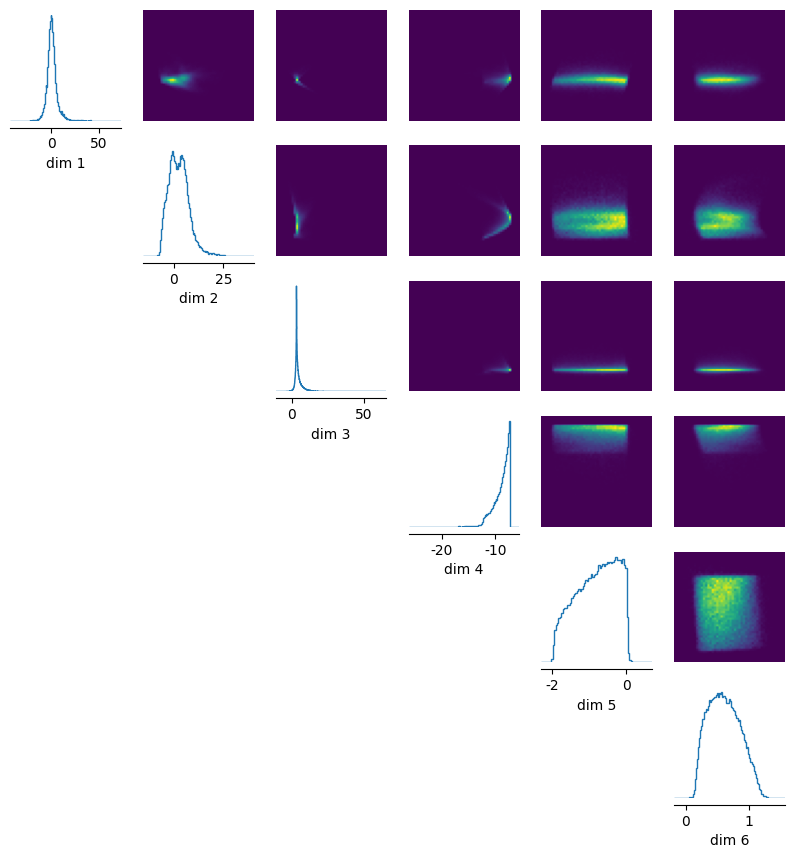

In [18]:
_,_,V = torch.pca_lowrank(md_samps)

_ = pairplot(md_samps@V)#,
            #  limits=[[0, 25], [-25,0], [0, 25], [-25,0], [0,1], [0,2]],
            #  figsize=(6, 6),
            #  labels=[r"$\tilde{W}_{EE}$", r"$\tilde{W}_{EI}$", r"$\tilde{W}_{IE}$", r"$\tilde{W}_{II}$", r"$r(\eta_E,\eta_I)$", r"$\eta_I/\eta_E$"])

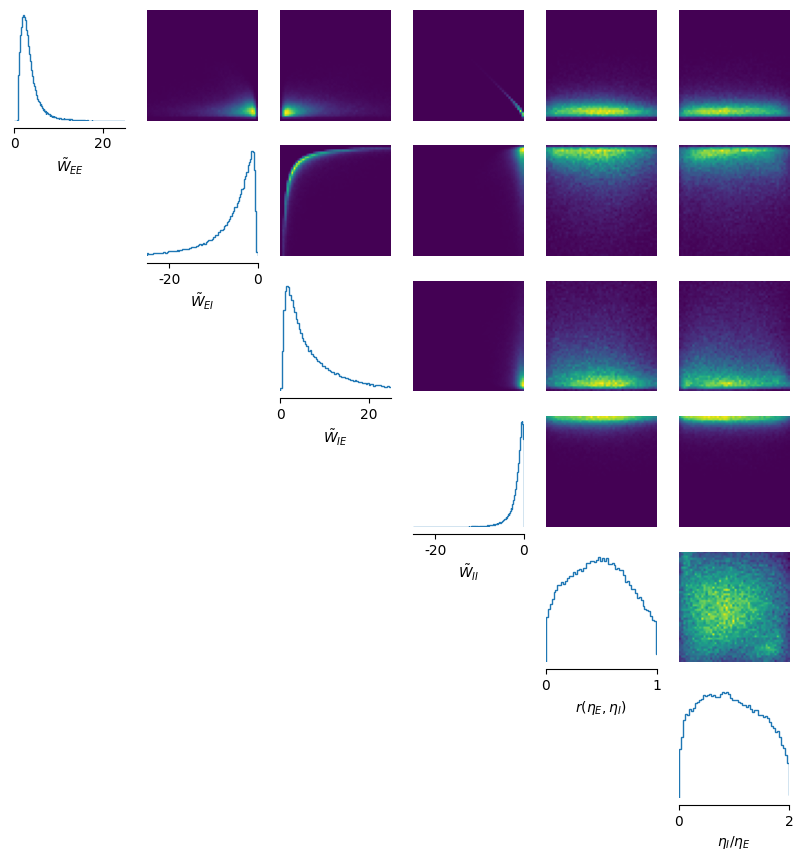

In [17]:
_ = pairplot(no_samps,
             limits=[[0, 25], [-25,0], [0, 25], [-25,0], [0,1], [0,2]],
             labels=[r"$\tilde{W}_{EE}$", r"$\tilde{W}_{EI}$", r"$\tilde{W}_{IE}$", r"$\tilde{W}_{II}$", r"$r(\eta_E,\eta_I)$", r"$\eta_I/\eta_E$"])

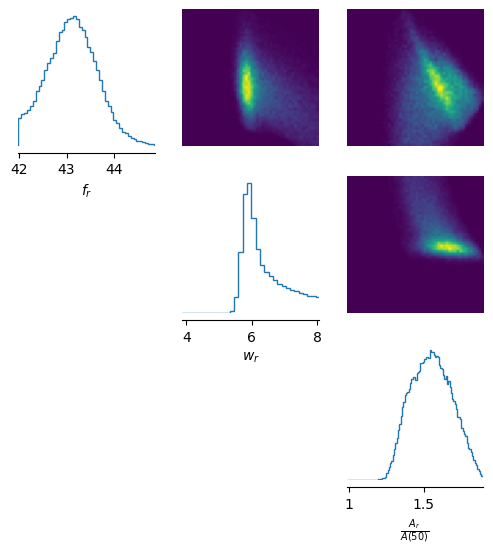

In [57]:
_ = pairplot(simulator(no_samps),
             limits=[[no_fr.n-no_fr.s, no_fr.n+no_fr.s],
                     [no_wr.n-no_wr.s, no_wr.n+no_wr.s],
                     [no_Ar50.n-no_Ar50.s, no_Ar50.n+no_Ar50.s]],
             figsize=(6, 6),
             labels=[r"$f_r$", r"$w_r$", r"$\frac{A_r}{A(50)}$"],
             diag_kwargs={'bins': 100})

Text(0, 0.5, 'Total Fraction Explained Variance')

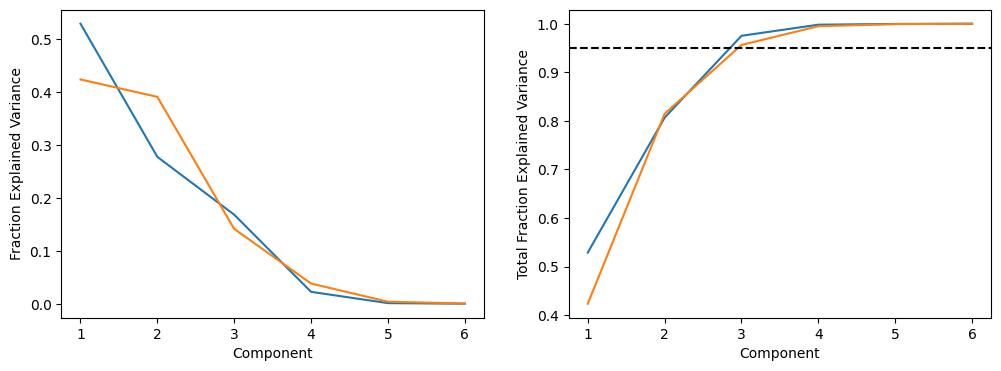

In [90]:
fig,axs = plt.subplots(1,2,figsize=(6*2,4*1))

_,S,V = torch.pca_lowrank(no_samps)
S = S**2
axs[0].plot(np.arange(6)+1,S/S.sum())
axs[1].plot(np.arange(6)+1,np.cumsum(S)/S.sum())

_,S,V = torch.pca_lowrank(md_samps)
S = S**2
axs[0].plot(np.arange(6)+1,S/S.sum())
axs[1].plot(np.arange(6)+1,np.cumsum(S)/S.sum())

axs[1].axhline(0.95,c='k',ls='--')

axs[0].set_xlabel('Component')
axs[1].set_xlabel('Component')
axs[0].set_ylabel('Fraction Explained Variance')
axs[1].set_ylabel('Total Fraction Explained Variance')

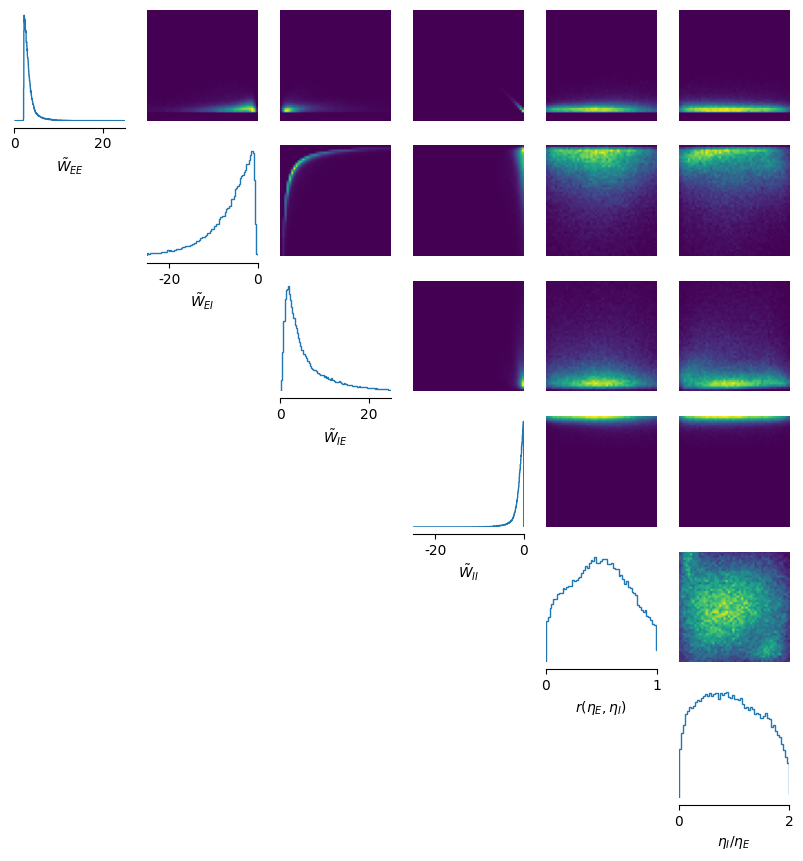

In [19]:
_ = pairplot(md_samps,
             limits=[[0, 25], [-25,0], [0, 25], [-25,0], [0,1], [0,2]],
            #  figsize=(6, 6),
             labels=[r"$\tilde{W}_{EE}$", r"$\tilde{W}_{EI}$", r"$\tilde{W}_{IE}$", r"$\tilde{W}_{II}$", r"$r(\eta_E,\eta_I)$", r"$\eta_I/\eta_E$"])

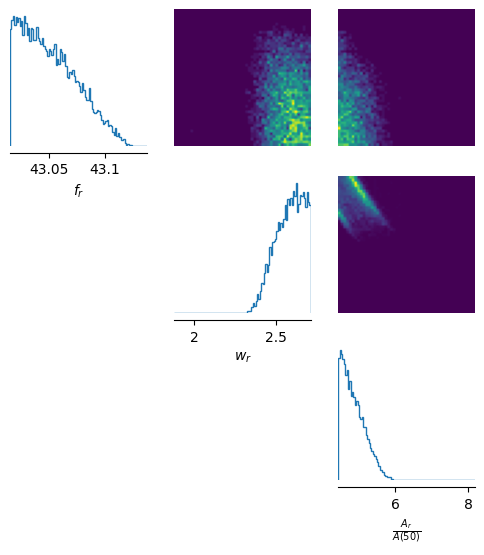

In [58]:
_ = pairplot(simulator(md_samps),
             limits=[[md_fr.n-md_fr.s, md_fr.n+md_fr.s],
                     [md_wr.n-md_wr.s, md_wr.n+md_wr.s],
                     [md_Ar50.n-md_Ar50.s, md_Ar50.n+md_Ar50.s]],
             figsize=(6, 6),
             labels=[r"$f_r$", r"$w_r$", r"$\frac{A_r}{A(50)}$"],
             diag_kwargs={'mpl_kwargs': {'bins': 100}})

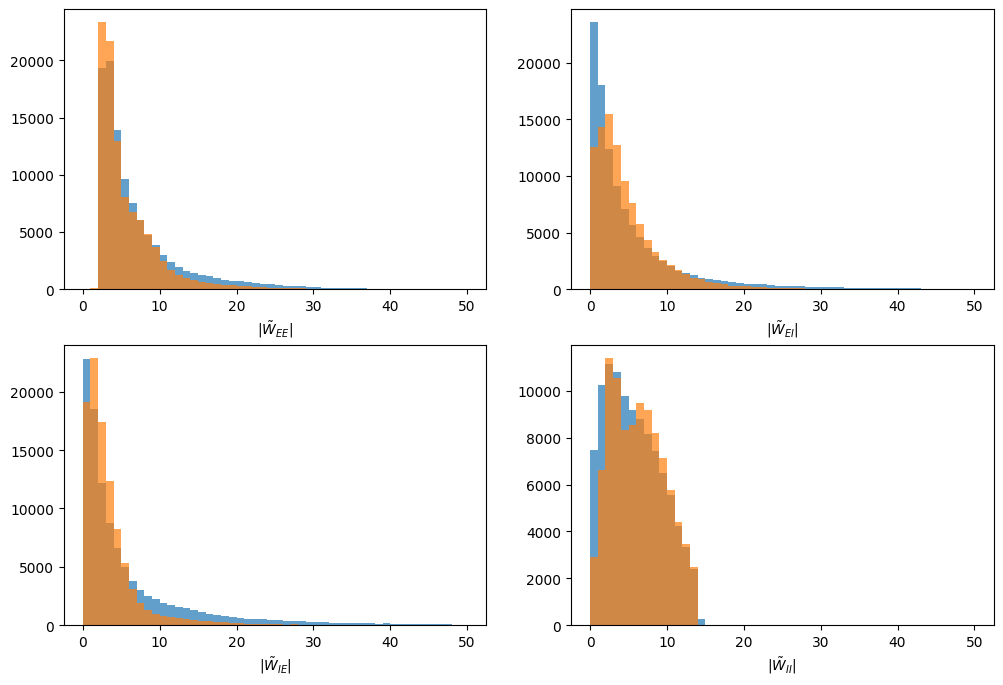

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(6*2,4*2))
axs = axs.ravel()

for i in range(4):
    axs[i].hist(np.abs(no_samps[:,i]),np.linspace(0,50,51),alpha=0.7)
    axs[i].hist(np.abs(md_samps[:,i]),np.linspace(0,50,51),alpha=0.7)
    axs[i].set_xlabel(r'$|\tilde{W}_{'+['EE','EI','IE','II'][i]+'}|$')

1.0246643683625198


Text(0, 0.5, '$|\\tilde{W}_{II}-1|$')

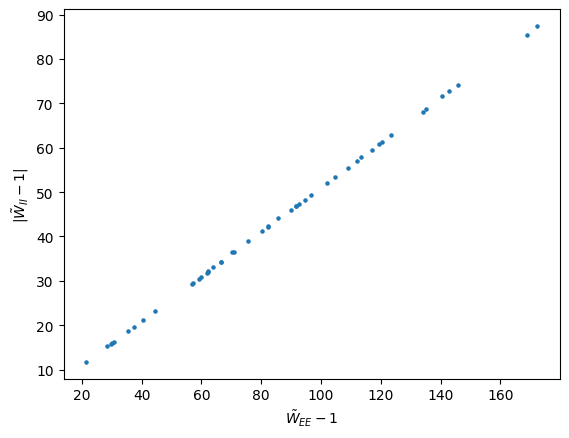

In [200]:
k,a = np.polyfit(np.log(samples[::10,0]),
                 np.log(-(samples[::10,3])),1)
a = np.exp(a)
print(k)

plt.scatter(samples[:,0]-1,-(samples[:,3]-1),s=5)
# plt.plot(np.linspace(20,200,100),a*np.linspace(20,200,100)**k,c='k',ls='--')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel(r'$\tilde{W}_{EE}-1$')
plt.ylabel(r'$|\tilde{W}_{II}-1|$')

0.2908782523568388 0.9102415847397165


Text(0, 0.5, '$|\\tilde{W}_{II}-1|$')

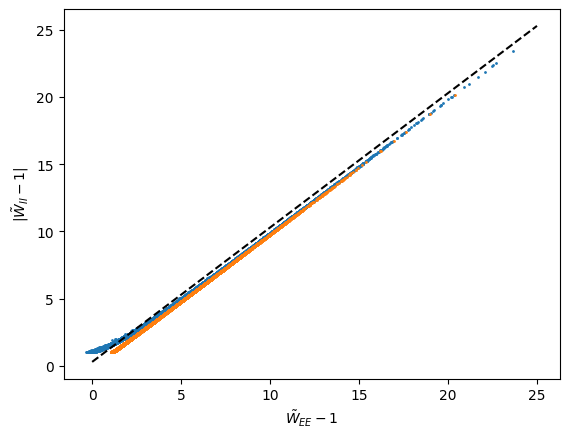

In [39]:
m,b = np.polyfit( (np.concatenate([no_samps[::100,0],md_samps[::100,0]])-1),
                 -(np.concatenate([no_samps[::100,3],md_samps[::100,3]])-1),1)
print(b,m)

plt.scatter((no_samps[:,0]-1),-(no_samps[:,3]-1),s=1)
plt.scatter((md_samps[:,0]-1),-(md_samps[:,3]-1),s=1)
plt.plot(np.linspace(0,25,100),b+np.linspace(0,25,100),c='k',ls='--')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel(r'$\tilde{W}_{EE}-1$')
plt.ylabel(r'$|\tilde{W}_{II}-1|$')

(array([  114.,   651.,  2223.,  5208.,  9605., 15334., 21441., 24394.,
        19691.,  6854.]),
 array([0.05331063, 0.07255461, 0.09179859, 0.11104257, 0.13028654,
        0.14953053, 0.16877452, 0.18801849, 0.20726247, 0.22650644,
        0.24575043]),
 <BarContainer object of 10 artists>)

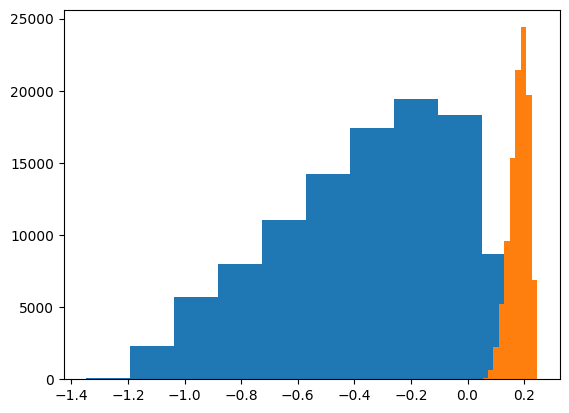

In [41]:
plt.hist((no_samps[:,0]-1)+(no_samps[:,3]-1))
plt.hist((md_samps[:,0]-1)+(md_samps[:,3]-1))

(array([155583., 166555., 120857., 115979., 118519., 120139., 115455.,
         99681.,  34515.,   5898.]),
 array([-131.82757568, -122.50291443, -113.1782608 , -103.85359955,
         -94.52894592,  -85.20428467,  -75.87962341,  -66.55496979,
         -57.23030853,  -47.90565109,  -38.58099365]),
 <BarContainer object of 10 artists>)

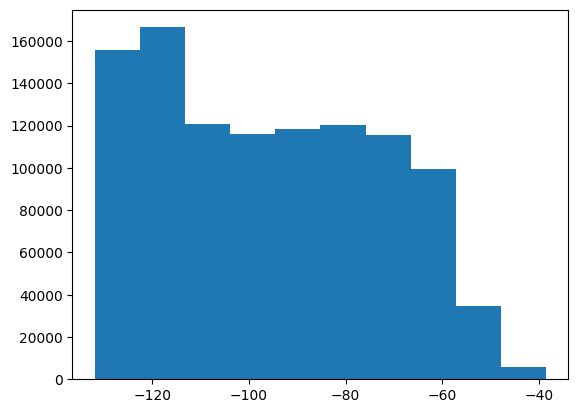

In [72]:
tr = -(no_samps[:,0]-1)/t[0] + (no_samps[:,3]-1)/t[1]
det = -((no_samps[:,0]-1)*(no_samps[:,3]-1) - no_samps[:,1]*no_samps[:,2])/t[0]/t[1]
# plt.hist(tr**2/4)
# plt.hist(det)
plt.hist(0.5*(tr + np.sqrt(np.fmax(0,tr**2-4*det))))

(array([ 74748., 131570., 183682., 199213., 200244., 145940.,  73136.,
         33842.,   9890.,    916.]),
 array([4.20070857e-01, 1.25740146e+04, 2.51476094e+04, 3.77212031e+04,
        5.02948008e+04, 6.28683945e+04, 7.54419922e+04, 8.80155859e+04,
        1.00589180e+05, 1.13162773e+05, 1.25736367e+05]),
 <BarContainer object of 10 artists>)

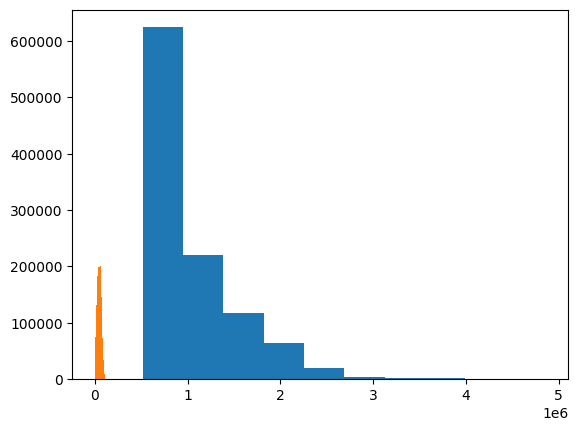

In [87]:
plt.hist(((no_samps[:,0]-1)/t[0]-(no_samps[:,3]-1)/t[1])**2)
plt.hist(-no_samps[:,1]*no_samps[:,2]/t[0]/t[1])
# plt.hist(((no_samps[:,0]-1)-(no_samps[:,3]-1))**2+no_samps[:,1]*no_samps[:,2])

(array([6.89700e+03, 3.43446e+05, 3.11188e+05, 1.77334e+05, 1.15527e+05,
        6.22390e+04, 2.61010e+04, 9.36000e+03, 1.06800e+03, 2.10000e+01]),
 array([0.05185552, 0.05328147, 0.05470743, 0.05613339, 0.05755935,
        0.05898532, 0.06041127, 0.06183723, 0.06326319, 0.06468915,
        0.06611511]),
 <BarContainer object of 10 artists>)

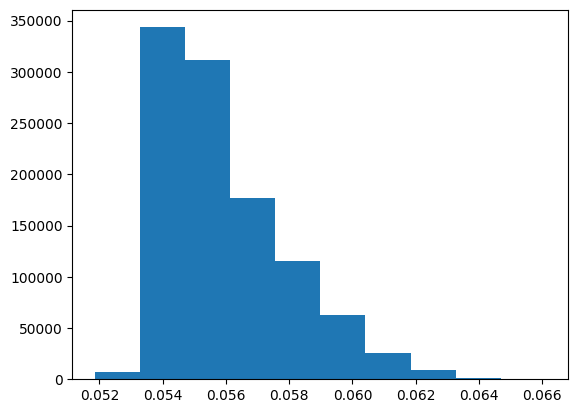

In [25]:
plt.hist((no_samps[:,0]-1)**k/-(no_samps[:,3]-1))

Text(0, 0.5, '$\\tilde{W}_{IE}$')

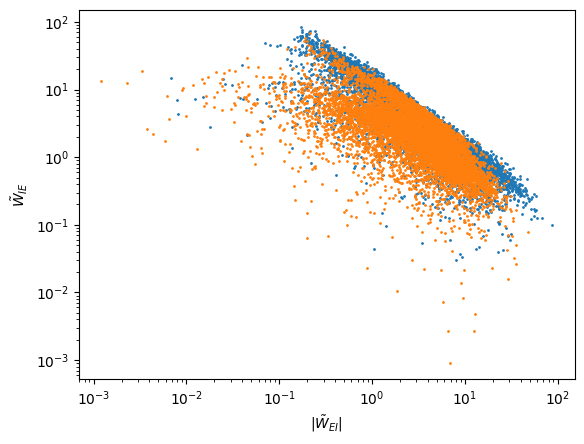

In [21]:
plt.scatter(-no_samps[no_samps[:,4]<0.01,1],no_samps[no_samps[:,4]<0.01,2],s=1)
plt.scatter(-md_samps[md_samps[:,4]<0.01,1],md_samps[md_samps[:,4]<0.01,2],s=1)
# plt.axvline(1,c='k',ls='--')
# plt.plot(np.linspace(2,25,100),35/np.linspace(2,25,100)**1.2,c='k',ls='--')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$|\tilde{W}_{EI}|$')
plt.ylabel(r'$\tilde{W}_{IE}$')

In [70]:
curve_fit(lambda x,A,k: A*x**k,torch.cat([no_samps[:,0],md_samps[:,0]]),torch.cat([-no_samps[:,3],-md_samps[:,3]]),p0=[40,-1.2])

/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_83579/2239654718.py:1: OptimizeWarning: Covariance of the parameters could not be estimated
  curve_fit(lambda x,A,k: A*x**k,torch.cat([no_samps[:,0],md_samps[:,0]]),torch.cat([-no_samps[:,3],-md_samps[:,3]]),p0=[40,-1.2])


(array([40.        , -1.30724941]),
 array([[inf, inf],
        [inf, inf]]))

In [ ]:
import pickle

with open('no_samps.pkl','wb') as handle:
    pickle.dump(no_samps,handle)

with open('md_samps.pkl','wb') as handle:
    pickle.dump(md_samps,handle)

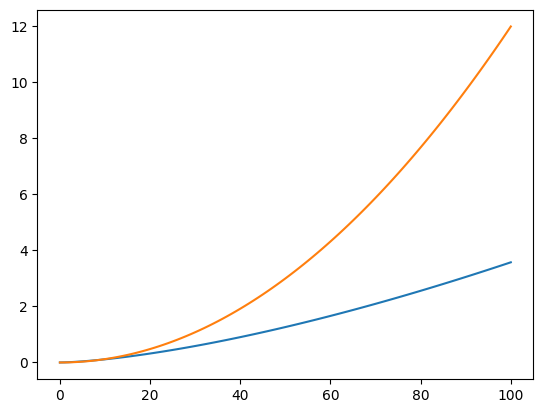

In [35]:
hs = np.linspace(0,20,101)
plt.plot(0.04*hs**1.5)
plt.plot(0.03*hs**2)

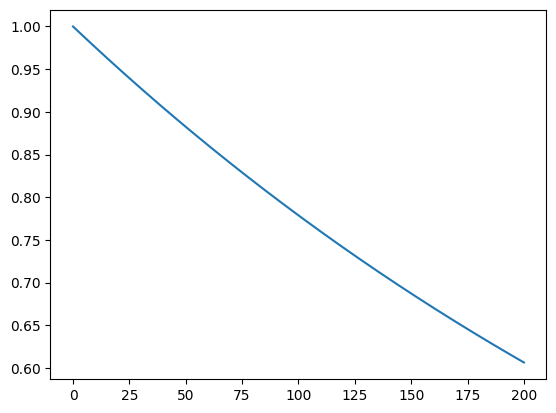

In [96]:
plt.plot(np.linspace(0,200,1001),np.exp(-0.05*np.linspace(0,200,1001)*0.05))